In [1]:
from sympy.printing.pytorch import torch

# 定义一个句子列表，后面会用这些句子来训练 CBOW 和 Skip-Gram 模型
sentences = [
    "Mazong is Boss",
    "Niuzong is Boss",
    "Xiaoniu is Worker",
    "Xiaoma is Worker"]
# 将所有句子连接在一起，然后用空格分隔成多个单词
words = ' '.join(sentences).split()
# 构建词汇表，去除重复的词
word_list = list(set(words))
# 创建一个字典，将每个词映射到一个唯一的索引
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到对应的词
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list) # 计算词汇表的大小
print(" 词汇表：", word_list) # 输出词汇表
print(" 词汇到索引的字典：", word_to_idx) # 输出词汇到索引的字典
print(" 索引到词汇的字典：", idx_to_word) # 输出索引到词汇的字典
print(" 词汇表大小：", voc_size) # 输出词汇表大小

 词汇表： ['is', 'Mazong', 'Xiaoma', 'Boss', 'Worker', 'Xiaoniu', 'Niuzong']
 词汇到索引的字典： {'is': 0, 'Mazong': 1, 'Xiaoma': 2, 'Boss': 3, 'Worker': 4, 'Xiaoniu': 5, 'Niuzong': 6}
 索引到词汇的字典： {0: 'is', 1: 'Mazong', 2: 'Xiaoma', 3: 'Boss', 4: 'Worker', 5: 'Xiaoniu', 6: 'Niuzong'}
 词汇表大小： 7


In [2]:
# 生成 Skip-Gram 训练数据
def create_skipgram_dataset(sentences, window_size=2):
    data = [] # 初始化数据
    for sentence in sentences: # 遍历句子
        sentence = sentence.split()  # 将句子分割成单词列表
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取相邻的单词，将当前单词前后各 N 个单词作为相邻单词
            for neighbor in sentence[max(idx - window_size, 0):
                        min(idx + window_size + 1, len(sentence))]:
                if neighbor != word:  # 排除当前单词本身
                    # 将相邻单词与当前单词作为一组训练数据
                    # data.append((neighbor, word))
                    data.append((word, neighbor))
    return data
# 使用函数创建 Skip-Gram 训练数据
skipgram_data = create_skipgram_dataset(sentences)
# 打印未编码的 Skip-Gram 数据样例（前 3 个）
print("Skip-Gram 数据样例（未编码）：", skipgram_data)

Skip-Gram 数据样例（未编码）： [('Mazong', 'is'), ('Mazong', 'Boss'), ('is', 'Mazong'), ('is', 'Boss'), ('Boss', 'Mazong'), ('Boss', 'is'), ('Niuzong', 'is'), ('Niuzong', 'Boss'), ('is', 'Niuzong'), ('is', 'Boss'), ('Boss', 'Niuzong'), ('Boss', 'is'), ('Xiaoniu', 'is'), ('Xiaoniu', 'Worker'), ('is', 'Xiaoniu'), ('is', 'Worker'), ('Worker', 'Xiaoniu'), ('Worker', 'is'), ('Xiaoma', 'is'), ('Xiaoma', 'Worker'), ('is', 'Xiaoma'), ('is', 'Worker'), ('Worker', 'Xiaoma'), ('Worker', 'is')]


In [3]:
# 定义 Skip-Gram 类
import torch.nn as nn # 导入 neural network
class SkipGram(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(SkipGram, self).__init__()
        # 从词汇表大小到隐藏层大小（维度）的线性层（权重矩阵）
        self.input_to_hidden = nn.Embedding(voc_size, embedding_size)
        # 从隐藏层大小（维度）到词汇表大小的线性层（权重矩阵）
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False)
    def forward(self, X): # 前向传播的方式，X 形状为 (batch_size, voc_size)
         # 通过隐藏层，hidden 形状为 (batch_size, embedding_size)
         hidden = self.input_to_hidden(X)
         # 通过输出层，output_layer 形状为 (batch_size, voc_size)
         output = self.hidden_to_output(hidden)
         return output
embedding_size = 2 # 设定嵌入层的大小，这里选择 2 是为了方便展示
skipgram_model = SkipGram(voc_size, embedding_size)  # 实例化 Skip-Gram 模型
print("Skip-Gram 模型：", skipgram_model)

Skip-Gram 模型： SkipGram(
  (input_to_hidden): Embedding(7, 2)
  (hidden_to_output): Linear(in_features=2, out_features=7, bias=False)
)


Epoch: 100, Loss: 1.8328618357578914
Epoch: 200, Loss: 1.7636273453632991
Epoch: 300, Loss: 1.711038962006569
Epoch: 400, Loss: 1.6685392533739407
Epoch: 500, Loss: 1.635159137348334
Epoch: 600, Loss: 1.609607773522536
Epoch: 700, Loss: 1.5893662547071774
Epoch: 800, Loss: 1.5722769473989804
Epoch: 900, Loss: 1.557189407447974
Epoch: 1000, Loss: 1.5436169107755024


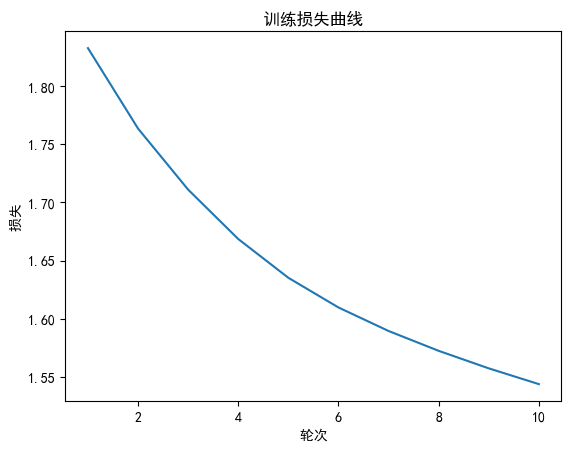

In [4]:
# 训练 Skip-Gram 类
learning_rate = 0.001 # 设置学习速率
epochs = 1000 # 设置训练轮次
criterion = nn.CrossEntropyLoss()  # 定义交叉熵损失函数
import torch.optim as optim # 导入随机梯度下降优化器
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)
# 开始训练循环
loss_values = []  # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0 # 初始化损失值
    # for context, target in skipgram_data:
    for center_word, context in skipgram_data:
        X = torch.tensor([word_to_idx[center_word]], dtype=torch.long) # 将中心词转换为 One-Hot 向量
        y_true = torch.tensor([word_to_idx[context]], dtype=torch.long) # 将周围词转换为索引值
        y_pred = skipgram_model(X)  # 计算预测值
        loss = criterion(y_pred, y_true)  # 计算损失
        loss_sum += loss.item() # 累积损失
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    if (epoch+1) % 100 == 0: # 输出每 100 轮的损失，并记录损失
      print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(skipgram_data)}")
      loss_values.append(loss_sum / len(skipgram_data))
# 绘制训练损失曲线
import matplotlib.pyplot as plt # 导入 matplotlib
# 绘制二维词向量图
plt.rcParams["font.family"]=['SimHei'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.plot(range(1, epochs//100 + 1), loss_values) # 绘图
plt.title(' 训练损失曲线 ') # 图题
plt.xlabel(' 轮次 ') # X 轴 Label
plt.ylabel(' 损失 ') # Y 轴 Label
plt.show() # 显示图

In [6]:
# 输出 Skip-Gram 习得的词嵌入
print("Skip-Gram 词嵌入：")
for word, idx in word_to_idx.items(): # 输出每个词的嵌入向量
 print(f"{word}: {skipgram_model.input_to_hidden.weight[idx].detach().numpy()}")

Skip-Gram 词嵌入：
is: [0.391673  1.4357942]
Mazong: [ 0.3337033 -0.9289578]
Xiaoma: [ 0.21118625 -0.8690738 ]
Boss: [-1.8066648  -0.79125726]
Worker: [ 0.87412363 -1.3688787 ]
Xiaoniu: [ 0.37941092 -0.2015772 ]
Niuzong: [ 0.77720994 -1.4386889 ]
